# Array Slicing with Overlapping Portions

This notebook implements a class that slices arrays into overlapping portions according to specific rules:

1. **First slice**: Take portion of rows, calculate original shape, drop last 30%
2. **Subsequent slices**: Start at 50% of previous original shape, drop 30% at start and end, merge with previous
3. **Last slice**: Don't drop the last part
4. **Merge**: Ensure no gaps in the final result

In [2]:
import numpy as np
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt

In [3]:
class ArraySlicer:
    """Class for slicing arrays into overlapping portions with specific drop rules.
    
    This class implements a sophisticated slicing strategy where:
    - First slice drops last 30% of rows
    - Subsequent slices start at 50% overlap and drop 30% from both ends
    - Final slice preserves the end portion
    - All slices are merged without gaps
    - Optional processing function can be applied to each slice before dropping
    
    Args:
        array (np.ndarray): Input array to be sliced
        slice_height (int): Height of each slice portion
        processing_func (Optional[callable]): Function to apply to each slice before dropping
    """
    
    def __init__(self, array: np.ndarray, slice_height: int, processing_func: Optional[callable] = None) -> None:
        """Initialize the ArraySlicer.
        
        Args:
            array (np.ndarray): Input array to slice
            slice_height (int): Height of each slice portion
            processing_func (Optional[callable]): Function to apply to each slice before dropping.
                Should accept (slice_data: np.ndarray, slice_info: dict) and return np.ndarray
            
        Raises:
            ValueError: If slice_height is larger than array height
            AssertionError: If input parameters are invalid
        """
        assert isinstance(array, np.ndarray), 'Input must be a numpy array'
        assert len(array.shape) >= 2, 'Array must be at least 2D'
        assert slice_height > 0, 'Slice height must be positive'
        
        if slice_height > array.shape[0]:
            raise ValueError(f'Slice height {slice_height} cannot be larger than array height {array.shape[0]}')
            
        self.array = array
        self.slice_height = slice_height
        self.processing_func = processing_func
        self.array_height, self.array_width = array.shape[:2]
        self.slices: List[np.ndarray] = []
        self.slice_info: List[dict] = []
        
    def slice_array(self) -> List[np.ndarray]:
        """Perform the complete slicing operation using calculate_slice_indices.
        
        Returns:
            List[np.ndarray]: List of sliced array portions
        """
        self.slices = []
        
        # Calculate all slice indices using the standalone function
        self.slice_info = calculate_slice_indices(self.array_height, self.slice_height)
        
        for slice_info in self.slice_info:
            # Extract the slice
            slice_data = self.array[slice_info['actual_start']:slice_info['actual_end']]
            
            # Apply processing function if provided
            if self.processing_func is not None:
                try:
                    slice_data = self.processing_func(slice_data, slice_info)
                    assert isinstance(slice_data, np.ndarray), 'Processing function must return numpy array'
                except Exception as e:
                    print(f'Warning: Processing function failed for slice {slice_info["slice_index"]}: {e}')
                    # Continue with original slice if processing fails
                    slice_data = self.array[slice_info['actual_start']:slice_info['actual_end']]
            
            self.slices.append(slice_data)
            
            # Update shape in slice_info after processing
            slice_info['shape'] = slice_data.shape
            
            print(f'Slice {slice_info["slice_index"]}: rows {slice_info["actual_start"]}-{slice_info["actual_end"]} '
                  f'(original: {slice_info["original_start"]}-{slice_info["original_end"]}) '
                  f'shape: {slice_data.shape}')
            
        return self.slices
    
    def merge_slices(self) -> np.ndarray:
        """Merge all slices back into a single array without gaps.
        
        Returns:
            np.ndarray: Merged array
        """
        if not self.slices:
            raise ValueError('No slices available. Call slice_array() first.')
            
        return np.concatenate(self.slices, axis=0)
    
    def get_slice_info(self) -> List[dict]:
        """Get detailed information about each slice.
        
        Returns:
            List[dict]: Information about each slice
        """
        return self.slice_info
    
    def visualize_slicing(self, figsize: Tuple[int, int] = (12, 8)) -> None:
        """Visualize the slicing process.
        
        Args:
            figsize (Tuple[int, int]): Figure size for the plot
        """
        if not self.slice_info:
            raise ValueError('No slice information available. Call slice_array() first.')
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot original array coverage
        ax1.set_title('Original Array Slicing Coverage')
        ax1.set_xlabel('Columns')
        ax1.set_ylabel('Rows')
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.slice_info)))
        
        for i, (info, color) in enumerate(zip(self.slice_info, colors)):
            # Show original slice boundaries
            rect_orig = plt.Rectangle(
                (0, info['original_start']), 
                self.array_width, 
                info['original_end'] - info['original_start'],
                fill=False, edgecolor=color, linewidth=2, linestyle='--',
                label=f'Slice {i} original'
            )
            ax1.add_patch(rect_orig)
            
            # Show actual slice after drops
            rect_actual = plt.Rectangle(
                (0, info['actual_start']), 
                self.array_width, 
                info['actual_end'] - info['actual_start'],
                fill=True, facecolor=color, alpha=0.3, edgecolor=color, linewidth=2,
                label=f'Slice {i} actual'
            )
            ax1.add_patch(rect_actual)
            
        ax1.set_xlim(0, self.array_width)
        ax1.set_ylim(0, self.array_height)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Plot merged result
        if self.slices:
            merged = self.merge_slices()
            ax2.imshow(merged, aspect='auto', cmap='viridis')
            ax2.set_title(f'Merged Result\nShape: {merged.shape}')
            ax2.set_xlabel('Columns')
            ax2.set_ylabel('Rows (Merged)')
        
        plt.tight_layout()
        plt.show()

In [4]:
def calculate_slice_indices(array_height: int, slice_height: int) -> List[dict]:
    """Calculate slice indices and drop information for array slicing.
    
    Args:
        array_height (int): Total height of the array to slice
        slice_height (int): Height of each slice portion
        
    Returns:
        List[dict]: List of dictionaries containing slice information with keys:
            - slice_index: Index of the slice
            - original_start: Original starting row
            - original_end: Original ending row
            - actual_start: Actual starting row after drops
            - actual_end: Actual ending row after drops
            - is_first: Whether this is the first slice
            - is_last: Whether this is the last slice
            - drop_start: Number of rows dropped from start
            - drop_end: Number of rows dropped from end
            - original_height: Height of original slice
            - actual_height: Height after drops
    """
    assert array_height > 0, 'Array height must be positive'
    assert slice_height > 0, 'Slice height must be positive'
    
    if slice_height > array_height:
        raise ValueError(f'Slice height {slice_height} cannot be larger than array height {array_height}')
    
    slice_info_list = []
    current_start = 0
    slice_index = 0
    last_actual_end = 0
    
    def _get_next_start_position(current_start: int) -> int:
        """Calculate the start position for the next slice (50% overlap)."""
        return current_start + int(0.5 * slice_height)
    
    def _calculate_drop_amounts(original_height: int, is_first: bool, is_last: bool) -> Tuple[int, int]:
        """Calculate drop amounts for start and end.
        
        Returns:
            Tuple[int, int]: (drop_start, drop_end)
        """
        if is_first:
            # First slice: drop last 30%
            drop_start = 0
            drop_end = int(0.3 * original_height)
        elif is_last:
            # Last slice: drop 30% from start, preserve end
            drop_start = int(0.3 * original_height)
            drop_end = 0
        else:
            # Middle slices: drop 30% from both ends
            drop_amount = int(0.3 * original_height)
            drop_start = drop_amount
            drop_end = drop_amount
            
        return drop_start, drop_end
    
    while current_start < array_height:
        # Determine if this is first or last slice
        is_first = slice_index == 0
        next_start = _get_next_start_position(current_start)
        is_last = next_start >= array_height
        
        # Calculate original slice boundaries
        original_end = min(current_start + slice_height, array_height)
        original_height = original_end - current_start
        
        # Calculate drop amounts
        drop_start, drop_end = _calculate_drop_amounts(original_height, is_first, is_last)
        
        # Calculate actual boundaries after drops
        actual_start = current_start + drop_start
        actual_end = original_end - drop_end
        
        # For non-first slices, ensure no gaps by starting where previous ended
        if not is_first:
            actual_start = last_actual_end
            # Recalculate drop_start based on adjusted actual_start
            drop_start = actual_start - current_start
        
        # Ensure we don't go beyond array bounds
        actual_start = max(0, actual_start)
        actual_end = min(array_height, actual_end)
        actual_height = actual_end - actual_start
        
        # Skip if slice would be empty
        if actual_start >= actual_end:
            break
        
        # Create slice information dictionary
        slice_info = {
            'slice_index': slice_index,
            'original_start': current_start,
            'original_end': original_end,
            'actual_start': actual_start,
            'actual_end': actual_end,
            'is_first': is_first,
            'is_last': is_last,
            'drop_start': drop_start,
            'drop_end': drop_end,
            'original_height': original_height,
            'actual_height': actual_height
        }
        
        slice_info_list.append(slice_info)
        
        # Update last_actual_end for next iteration
        last_actual_end = actual_end
        
        # Break if this was the last slice or we've reached the end
        if is_last or actual_end >= array_height:
            break
        
        # Move to next slice position
        current_start = next_start
        slice_index += 1
    
    return slice_info_list

## Example Usage

Let's test the ArraySlicer with different scenarios:

## Standalone Slice Index Calculation

The `calculate_slice_indices` function provides a standalone way to calculate slice indices and drop information without creating arrays. This is useful for planning, analysis, or when you only need the indexing information.

In [6]:
# Test the standalone calculate_slice_indices function
print('Testing standalone calculate_slice_indices function:')
print('=' * 60)

# Calculate slice indices for our test array
array_height = 60000
slice_height = 10000

slice_indices = calculate_slice_indices(array_height, slice_height)

print(f'Array height: {array_height}, Slice height: {slice_height}')
print(f'Number of slices calculated: {len(slice_indices)}')
print()

# Display detailed information about each slice
print('Detailed slice information:')
print('-' * 80)
for info in slice_indices:
    print(f"Slice {info['slice_index']:2d}: "
          f"original[{info['original_start']:2d}:{info['original_end']:2d}] "
          f"-> actual[{info['actual_start']:2d}:{info['actual_end']:2d}] "
          f"(drop_start:{info['drop_start']:2d}, drop_end:{info['drop_end']:2d}) "
          f"{'FIRST' if info['is_first'] else 'LAST' if info['is_last'] else 'MIDDLE'}")

# Verify no gaps
print('\nGap analysis:')
for i in range(len(slice_indices) - 1):
    current_end = slice_indices[i]['actual_end']
    next_start = slice_indices[i + 1]['actual_start']
    gap = next_start - current_end
    status = 'OK' if gap == 0 else f'GAP: {gap}' if gap > 0 else f'OVERLAP: {-gap}'
    print(f'  Between slice {i} and {i+1}: {status}')

# Calculate total coverage
total_coverage = sum(info['actual_height'] for info in slice_indices)
print(f'\nTotal coverage: {total_coverage} rows out of {array_height} original rows')
print(f'Coverage percentage: {(total_coverage/array_height)*100:.1f}%')

Testing standalone calculate_slice_indices function:
Array height: 60000, Slice height: 10000
Number of slices calculated: 12

Detailed slice information:
--------------------------------------------------------------------------------
Slice  0: original[ 0:10000] -> actual[ 0:7000] (drop_start: 0, drop_end:3000) FIRST
Slice  1: original[5000:15000] -> actual[7000:12000] (drop_start:2000, drop_end:3000) MIDDLE
Slice  2: original[10000:20000] -> actual[12000:17000] (drop_start:2000, drop_end:3000) MIDDLE
Slice  3: original[15000:25000] -> actual[17000:22000] (drop_start:2000, drop_end:3000) MIDDLE
Slice  4: original[20000:30000] -> actual[22000:27000] (drop_start:2000, drop_end:3000) MIDDLE
Slice  5: original[25000:35000] -> actual[27000:32000] (drop_start:2000, drop_end:3000) MIDDLE
Slice  6: original[30000:40000] -> actual[32000:37000] (drop_start:2000, drop_end:3000) MIDDLE
Slice  7: original[35000:45000] -> actual[37000:42000] (drop_start:2000, drop_end:3000) MIDDLE
Slice  8: origin

In [7]:
# Compare different slice heights
print('\nComparing different slice heights:')
print('=' * 60)

slice_heights = [20, 30, 40, 60]
array_height = 100

for sh in slice_heights:
    try:
        indices = calculate_slice_indices(array_height, sh)
        total_coverage = sum(info['actual_height'] for info in indices)
        coverage_pct = (total_coverage/array_height)*100
        
        print(f'Slice height {sh:2d}: {len(indices)} slices, '
              f'{total_coverage:3d}/{array_height} rows ({coverage_pct:5.1f}% coverage)')
        
        # Show slice breakdown
        breakdown = []
        for info in indices:
            slice_type = 'F' if info['is_first'] else 'L' if info['is_last'] else 'M'
            breakdown.append(f"{slice_type}:{info['actual_height']}")
        print(f'              Breakdown: {" + ".join(breakdown)}')
        print()
        
    except ValueError as e:
        print(f'Slice height {sh:2d}: ERROR - {e}')
        print()


Comparing different slice heights:
Slice height 20: 10 slices, 100/100 rows (100.0% coverage)
              Breakdown: F:14 + M:10 + M:10 + M:10 + M:10 + M:10 + M:10 + M:10 + M:10 + L:6

Slice height 30: 7 slices, 100/100 rows (100.0% coverage)
              Breakdown: F:21 + M:15 + M:15 + M:15 + M:15 + M:12 + L:7

Slice height 40: 5 slices, 100/100 rows (100.0% coverage)
              Breakdown: F:28 + M:20 + M:20 + M:20 + L:12

Slice height 60: 4 slices, 100/100 rows (100.0% coverage)
              Breakdown: F:42 + M:30 + M:16 + L:12



In [8]:
# Test with different array sizes
print('Testing with different array sizes:')
print('=' * 60)

test_cases = [
    (50, 20),   # Small array
    (100, 30),  # Medium array
    (200, 50),  # Large array
    (25, 10),   # Very small array
]

for array_h, slice_h in test_cases:
    try:
        indices = calculate_slice_indices(array_h, slice_h)
        total_coverage = sum(info['actual_height'] for info in indices)
        
        print(f'Array {array_h:3d}, Slice {slice_h:2d}: '
              f'{len(indices)} slices, {total_coverage:3d} total rows')
        
        # Show first and last slice details
        if indices:
            first = indices[0]
            last = indices[-1]
            print(f'    First: [{first["actual_start"]}:{first["actual_end"]}] '
                  f'height={first["actual_height"]} (dropped {first["drop_end"]} from end)')
            print(f'    Last:  [{last["actual_start"]}:{last["actual_end"]}] '
                  f'height={last["actual_height"]} (dropped {last["drop_start"]} from start)')
        print()
        
    except (ValueError, AssertionError) as e:
        print(f'Array {array_h:3d}, Slice {slice_h:2d}: ERROR - {e}')
        print()

Testing with different array sizes:
Array  50, Slice 20: 5 slices,  50 total rows
    First: [0:14] height=14 (dropped 6 from end)
    Last:  [44:50] height=6 (dropped 4 from start)

Array 100, Slice 30: 7 slices, 100 total rows
    First: [0:21] height=21 (dropped 9 from end)
    Last:  [93:100] height=7 (dropped 3 from start)

Array 200, Slice 50: 8 slices, 200 total rows
    First: [0:35] height=35 (dropped 15 from end)
    Last:  [185:200] height=15 (dropped 10 from start)

Array  25, Slice 10: 5 slices,  25 total rows
    First: [0:7] height=7 (dropped 3 from end)
    Last:  [22:25] height=3 (dropped 2 from start)



In [9]:
# Example: Using slice indices for custom processing without ArraySlicer
print('Custom slicing example using only slice indices:')
print('=' * 60)

# Create a simple test array
custom_array = np.arange(60).reshape(12, 5)
print(f'Custom array shape: {custom_array.shape}')
print('Custom array:')
print(custom_array)
print()

# Get slice indices
custom_indices = calculate_slice_indices(custom_array.shape[0], slice_height=5)

# Process each slice manually
processed_slices = []
for info in custom_indices:
    # Extract slice
    slice_data = custom_array[info['actual_start']:info['actual_end']]
    
    # Apply custom processing (e.g., multiply by slice index)
    processed_slice = slice_data * (info['slice_index'] + 1)
    processed_slices.append(processed_slice)
    
    print(f'Slice {info["slice_index"]}: rows {info["actual_start"]}-{info["actual_end"]} '
          f'(multiplied by {info["slice_index"] + 1})')
    print(processed_slice)
    print()

# Merge manually
merged_custom = np.concatenate(processed_slices, axis=0)
print(f'Merged result shape: {merged_custom.shape}')
print('Merged result:')
print(merged_custom)

Custom slicing example using only slice indices:
Custom array shape: (12, 5)
Custom array:
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]
 [30 31 32 33 34]
 [35 36 37 38 39]
 [40 41 42 43 44]
 [45 46 47 48 49]
 [50 51 52 53 54]
 [55 56 57 58 59]]

Slice 0: rows 0-4 (multiplied by 1)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

Slice 1: rows 4-6 (multiplied by 2)
[[40 42 44 46 48]
 [50 52 54 56 58]]

Slice 2: rows 6-8 (multiplied by 3)
[[ 90  93  96  99 102]
 [105 108 111 114 117]]

Slice 3: rows 8-10 (multiplied by 4)
[[160 164 168 172 176]
 [180 184 188 192 196]]

Slice 4: rows 10-11 (multiplied by 5)
[[250 255 260 265 270]]

Slice 5: rows 11-12 (multiplied by 6)
[[330 336 342 348 354]]

Merged result shape: (12, 5)
Merged result:
[[  0   1   2   3   4]
 [  5   6   7   8   9]
 [ 10  11  12  13  14]
 [ 15  16  17  18  19]
 [ 40  42  44  46  48]
 [ 50  52  54  56  58]
 [ 90  93  96  99 102]
 [105 1

In [10]:
def visualize_slice_indices(slice_indices: List[dict], array_height: int, title: str = 'Slice Indices Visualization'):
    """Visualize slice indices information.
    
    Args:
        slice_indices (List[dict]): Output from calculate_slice_indices
        array_height (int): Total height of the array
        title (str): Title for the plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(slice_indices)))
    
    for i, (info, color) in enumerate(zip(slice_indices, colors)):
        # Show original slice boundaries (dashed)
        ax.barh(i, info['original_height'], left=info['original_start'], 
               height=0.3, alpha=0.3, color=color, 
               label=f'Slice {i} original' if i < 3 else None)
        
        # Show actual slice after drops (solid)
        ax.barh(i, info['actual_height'], left=info['actual_start'], 
               height=0.6, alpha=0.8, color=color,
               label=f'Slice {i} actual' if i < 3 else None)
        
        # Add text annotations
        mid_point = (info['actual_start'] + info['actual_end']) / 2
        slice_type = 'FIRST' if info['is_first'] else 'LAST' if info['is_last'] else 'MIDDLE'
        ax.text(mid_point, i, f'{slice_type}\n{info["actual_height"]} rows', 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax.set_xlim(0, array_height)
    ax.set_ylim(-0.5, len(slice_indices) - 0.5)
    ax.set_xlabel('Array Rows')
    ax.set_ylabel('Slice Index')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Visualize our slice indices
visualize_slice_indices(slice_indices, array_height, 
                       f'Slice Indices for Array Height {array_height}, Slice Height {slice_height}')

/tmp/ipykernel_2660396/1580832135.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


### Benefits of the Refactored Approach

The new `calculate_slice_indices` function provides several advantages:

1. **Separation of Concerns**: Index calculation is separated from array processing
2. **Reusability**: Can be used independently without creating ArraySlicer instances
3. **Planning and Analysis**: Calculate slice information before processing large arrays
4. **Memory Efficiency**: Plan slicing strategy without loading data
5. **Debugging**: Easier to debug slicing logic without array operations
6. **Flexibility**: Use the indices with custom processing logic
7. **Rich Information**: Returns comprehensive dictionary with all slice metadata

**Dictionary Keys Returned by `calculate_slice_indices`:**
- `slice_index`: Index of the slice
- `original_start`, `original_end`: Original boundaries
- `actual_start`, `actual_end`: Actual boundaries after drops
- `is_first`, `is_last`: Boolean flags for slice type
- `drop_start`, `drop_end`: Number of rows dropped
- `original_height`, `actual_height`: Heights before and after drops

In [3]:
# Create a test array with identifiable values
test_height, test_width = 100, 50
test_array = np.arange(test_height * test_width).reshape(test_height, test_width)

print(f'Original array shape: {test_array.shape}')
print(f'Array values range: {test_array.min()} to {test_array.max()}')

# Display a portion of the array to see the pattern
print('\nFirst few rows of the array:')
print(test_array[:5, :10])

Original array shape: (100, 50)
Array values range: 0 to 4999

First few rows of the array:
[[  0   1   2   3   4   5   6   7   8   9]
 [ 50  51  52  53  54  55  56  57  58  59]
 [100 101 102 103 104 105 106 107 108 109]
 [150 151 152 153 154 155 156 157 158 159]
 [200 201 202 203 204 205 206 207 208 209]]


In [19]:
# Test with slice height of 30
slice_height = 30
slicer = ArraySlicer(test_array, slice_height)

print(f'\nSlicing array with slice_height={slice_height}')
print('=' * 50)

# Perform slicing
slices = slicer.slice_array()

print(f'\nNumber of slices created: {len(slices)}')
print('\nSlice details:')
for i, slice_data in enumerate(slices):
    info = slicer.get_slice_info()[i]
    print(f'  Slice {i}: shape {slice_data.shape}, '
          f'rows {info["actual_start"]}-{info["actual_end"]}, '
          f'type: {"first" if info["is_first"] else "last" if info["is_last"] else "middle"}')


Slicing array with slice_height=30
Slice 0: rows 0-21 (original: 0-30) shape: (21, 50)
Slice 1: rows 21-36 (original: 15-45) shape: (15, 50)
Slice 2: rows 36-51 (original: 30-60) shape: (15, 50)
Slice 3: rows 51-66 (original: 45-75) shape: (15, 50)
Slice 4: rows 66-81 (original: 60-90) shape: (15, 50)
Slice 5: rows 81-93 (original: 75-100) shape: (12, 50)
Slice 6: rows 93-100 (original: 90-100) shape: (7, 50)

Number of slices created: 7

Slice details:
  Slice 0: shape (21, 50), rows 0-21, type: first
  Slice 1: shape (15, 50), rows 21-36, type: middle
  Slice 2: shape (15, 50), rows 36-51, type: middle
  Slice 3: shape (15, 50), rows 51-66, type: middle
  Slice 4: shape (15, 50), rows 66-81, type: middle
  Slice 5: shape (12, 50), rows 81-93, type: middle
  Slice 6: shape (7, 50), rows 93-100, type: last


In [5]:
# Merge the slices
merged_array = slicer.merge_slices()

print(f'\nMerged array shape: {merged_array.shape}')
print(f'Original array height: {test_array.shape[0]}')
print(f'Merged array height: {merged_array.shape[0]}')

# Check if we have the expected coverage
total_rows_processed = sum(info['actual_end'] - info['actual_start'] 
                          for info in slicer.get_slice_info())
print(f'Total rows in all slices: {total_rows_processed}')

# Verify no gaps by checking continuity
slice_info = slicer.get_slice_info()
print('\nChecking for gaps:')
for i in range(len(slice_info) - 1):
    current_end = slice_info[i]['actual_end']
    next_start = slice_info[i + 1]['actual_start']
    gap = next_start - current_end
    print(f'  Between slice {i} and {i+1}: gap = {gap} rows')
    if gap > 0:
        print(f'    WARNING: Gap detected!')
    elif gap < 0:
        print(f'    Overlap of {-gap} rows')


Merged array shape: (100, 50)
Original array height: 100
Merged array height: 100
Total rows in all slices: 100

Checking for gaps:
  Between slice 0 and 1: gap = 0 rows
  Between slice 1 and 2: gap = 0 rows
  Between slice 2 and 3: gap = 0 rows
  Between slice 3 and 4: gap = 0 rows
  Between slice 4 and 5: gap = 0 rows
  Between slice 5 and 6: gap = 0 rows


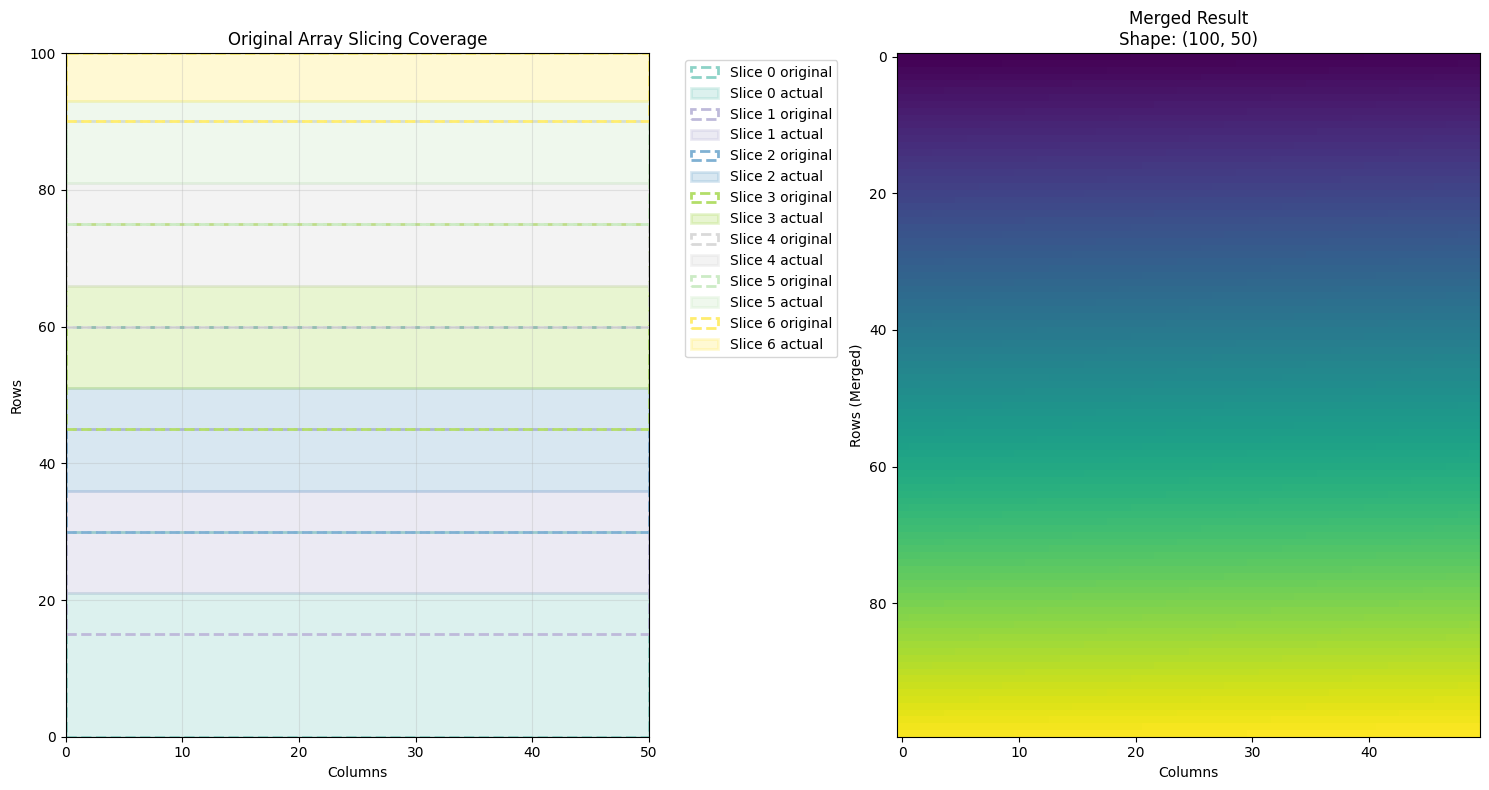

In [6]:
# Visualize the slicing process
slicer.visualize_slicing(figsize=(15, 8))

## Using Processing Functions

The `ArraySlicer` now supports applying a custom function to each slice before the dropping rules are applied. This allows for preprocessing, filtering, or transformation of each slice.

In [11]:
# Define some example processing functions

def normalize_slice(slice_data: np.ndarray, slice_info: dict) -> np.ndarray:
    """Normalize each slice to have zero mean and unit variance.
    
    Args:
        slice_data (np.ndarray): The slice to process
        slice_info (dict): Information about the slice
        
    Returns:
        np.ndarray: Normalized slice
    """
    mean_val = np.mean(slice_data)
    std_val = np.std(slice_data)
    if std_val > 0:
        normalized = (slice_data - mean_val) / std_val
    else:
        normalized = slice_data - mean_val
    
    print(f"  Normalized slice {slice_info['slice_index']}: mean={mean_val:.2f}, std={std_val:.2f}")
    return normalized

def apply_gaussian_filter(slice_data: np.ndarray, slice_info: dict) -> np.ndarray:
    """Apply Gaussian smoothing to each slice.
    
    Args:
        slice_data (np.ndarray): The slice to process
        slice_info (dict): Information about the slice
        
    Returns:
        np.ndarray: Smoothed slice
    """
    from scipy import ndimage
    smoothed = ndimage.gaussian_filter(slice_data.astype(float), sigma=1.0)
    print(f"  Applied Gaussian filter to slice {slice_info['slice_index']}")
    return smoothed

def add_slice_metadata(slice_data: np.ndarray, slice_info: dict) -> np.ndarray:
    """Add metadata information as extra columns to the slice.
    
    Args:
        slice_data (np.ndarray): The slice to process
        slice_info (dict): Information about the slice
        
    Returns:
        np.ndarray: Slice with added metadata columns
    """
    # Add two columns: slice index and row position within slice
    metadata = np.zeros((slice_data.shape[0], 2))
    metadata[:, 0] = slice_info['slice_index']  # Slice index
    metadata[:, 1] = np.arange(slice_data.shape[0])  # Row index within slice
    
    enhanced_slice = np.concatenate([slice_data, metadata], axis=1)
    print(f"  Added metadata to slice {slice_info['slice_index']}: {slice_data.shape} -> {enhanced_slice.shape}")
    return enhanced_slice

In [12]:
# Test with normalization function
print('Testing ArraySlicer with normalization function:')
print('=' * 60)

norm_slicer = ArraySlicer(test_array, slice_height=30, processing_func=normalize_slice)
norm_slices = norm_slicer.slice_array()

print(f'\nNumber of normalized slices: {len(norm_slices)}')
print('First slice statistics after normalization:')
first_norm_slice = norm_slices[0]
print(f'  Shape: {first_norm_slice.shape}')
print(f'  Mean: {np.mean(first_norm_slice):.6f}')
print(f'  Std: {np.std(first_norm_slice):.6f}')
print(f'  Min: {np.min(first_norm_slice):.2f}')
print(f'  Max: {np.max(first_norm_slice):.2f}')

Testing ArraySlicer with normalization function:
  Normalized slice 0: mean=524.50, std=303.11
Slice 0: rows 0-21 (original: 0-30) shape: (21, 50)
  Normalized slice 1: mean=1424.50, std=216.51
Slice 1: rows 21-36 (original: 15-45) shape: (15, 50)
  Normalized slice 2: mean=2174.50, std=216.51
Slice 2: rows 36-51 (original: 30-60) shape: (15, 50)
  Normalized slice 3: mean=2924.50, std=216.51
Slice 3: rows 51-66 (original: 45-75) shape: (15, 50)
  Normalized slice 4: mean=3674.50, std=216.51
Slice 4: rows 66-81 (original: 60-90) shape: (15, 50)
  Normalized slice 5: mean=4349.50, std=173.20
Slice 5: rows 81-93 (original: 75-100) shape: (12, 50)
  Normalized slice 6: mean=4824.50, std=101.04
Slice 6: rows 93-100 (original: 90-100) shape: (7, 50)

Number of normalized slices: 7
First slice statistics after normalization:
  Shape: (21, 50)
  Mean: 0.000000
  Std: 1.000000
  Min: -1.73
  Max: 1.73


In [13]:
# Test with metadata addition function
print('\nTesting ArraySlicer with metadata addition:')
print('=' * 60)

meta_slicer = ArraySlicer(test_array, slice_height=30, processing_func=add_slice_metadata)
meta_slices = meta_slicer.slice_array()

print(f'\nNumber of slices with metadata: {len(meta_slices)}')
print('Shape changes:')
for i, slice_data in enumerate(meta_slices):
    info = meta_slicer.get_slice_info()[i]
    original_shape = (info['actual_end'] - info['actual_start'], test_array.shape[1])
    print(f'  Slice {i}: {original_shape} -> {slice_data.shape}')

print('\nSample metadata from first slice (last 2 columns):')
print('  [slice_index, row_in_slice]')
print(meta_slices[0][:5, -2:])  # Show first 5 rows, last 2 columns


Testing ArraySlicer with metadata addition:
  Added metadata to slice 0: (21, 50) -> (21, 52)
Slice 0: rows 0-21 (original: 0-30) shape: (21, 52)
  Added metadata to slice 1: (15, 50) -> (15, 52)
Slice 1: rows 21-36 (original: 15-45) shape: (15, 52)
  Added metadata to slice 2: (15, 50) -> (15, 52)
Slice 2: rows 36-51 (original: 30-60) shape: (15, 52)
  Added metadata to slice 3: (15, 50) -> (15, 52)
Slice 3: rows 51-66 (original: 45-75) shape: (15, 52)
  Added metadata to slice 4: (15, 50) -> (15, 52)
Slice 4: rows 66-81 (original: 60-90) shape: (15, 52)
  Added metadata to slice 5: (12, 50) -> (12, 52)
Slice 5: rows 81-93 (original: 75-100) shape: (12, 52)
  Added metadata to slice 6: (7, 50) -> (7, 52)
Slice 6: rows 93-100 (original: 90-100) shape: (7, 52)

Number of slices with metadata: 7
Shape changes:
  Slice 0: (21, 50) -> (21, 52)
  Slice 1: (15, 50) -> (15, 52)
  Slice 2: (15, 50) -> (15, 52)
  Slice 3: (15, 50) -> (15, 52)
  Slice 4: (15, 50) -> (15, 52)
  Slice 5: (12, 50)

In [14]:
# Test error handling with a faulty processing function
def faulty_function(slice_data: np.ndarray, slice_info: dict) -> np.ndarray:
    """A function that fails on purpose for certain slices."""
    if slice_info['slice_index'] == 2:  # Fail on slice 2
        raise ValueError('Intentional failure for testing')
    return slice_data * 2  # Double the values

print('\nTesting error handling with faulty processing function:')
print('=' * 60)

faulty_slicer = ArraySlicer(test_array, slice_height=30, processing_func=faulty_function)
faulty_slices = faulty_slicer.slice_array()

print(f'\nProcessing completed despite error. Number of slices: {len(faulty_slices)}')
print('Checking if slice 2 was processed (should be original values):')
original_slice_2_start = faulty_slicer.get_slice_info()[2]['actual_start']
original_slice_2_end = faulty_slicer.get_slice_info()[2]['actual_end']
original_values = test_array[original_slice_2_start:original_slice_2_end, 0][:3]
processed_values = faulty_slices[2][:3, 0]
print(f'  Original values: {original_values}')
print(f'  Processed values: {processed_values}')
print(f'  Values match (error handling worked): {np.array_equal(original_values, processed_values)}')


Testing error handling with faulty processing function:
Slice 0: rows 0-21 (original: 0-30) shape: (21, 50)
Slice 1: rows 21-36 (original: 15-45) shape: (15, 50)
Slice 2: rows 36-51 (original: 30-60) shape: (15, 50)
Slice 3: rows 51-66 (original: 45-75) shape: (15, 50)
Slice 4: rows 66-81 (original: 60-90) shape: (15, 50)
Slice 5: rows 81-93 (original: 75-100) shape: (12, 50)
Slice 6: rows 93-100 (original: 90-100) shape: (7, 50)

Processing completed despite error. Number of slices: 7
Checking if slice 2 was processed (should be original values):
  Original values: [1800 1850 1900]
  Processed values: [1800 1850 1900]
  Values match (error handling worked): True


In [ ]:
# Create a chained processing function
def chained_processing(slice_data: np.ndarray, slice_info: dict) -> np.ndarray:
    """Apply multiple processing steps in sequence.
    
    Args:
        slice_data (np.ndarray): The slice to process
        slice_info (dict): Information about the slice
        
    Returns:
        np.ndarray: Processed slice
    """
    # Step 1: Convert to float and apply small Gaussian smoothing
    from scipy import ndimage
    processed = slice_data.astype(float)
    processed = ndimage.gaussian_filter(processed, sigma=0.5)
    
    # Step 2: Normalize
    mean_val = np.mean(processed)
    std_val = np.std(processed)
    if std_val > 0:
        processed = (processed - mean_val) / std_val
    else:
        processed = processed - mean_val
    
    # Step 3: Clip extreme values
    processed = np.clip(processed, -3, 3)
    
    print(f"  Applied chained processing to slice {slice_info['slice_index']}")
    return processed

print('\nTesting chained processing function:')
print('=' * 60)

chained_slicer = ArraySlicer(test_array, slice_height=30, processing_func=chained_processing)
chained_slices = chained_slicer.slice_array()

print(f'\nChained processing completed. Number of slices: {len(chained_slices)}')
print('Statistics of processed slices:')
for i, slice_data in enumerate(chained_slices[:3]):  # Show first 3 slices
    print(f'  Slice {i}: mean={np.mean(slice_data):.6f}, std={np.std(slice_data):.6f}, '
          f'min={np.min(slice_data):.2f}, max={np.max(slice_data):.2f}')

**Note**: Some of the processing functions above use `scipy.ndimage` for Gaussian filtering. If you don't have scipy installed, you can install it with:
```bash
pip install scipy
```
Or skip the Gaussian filtering examples and use the other processing functions.

In [ ]:
# Visualize results with different processing functions
# Note: Visualization works best with normalized data
if len(norm_slices) > 0:
    print('\nVisualizing normalized slices:')
    norm_slicer.visualize_slicing(figsize=(15, 8))
else:
    print('\nSkipping visualization - no normalized slices available')

### Practical Usage Examples

The processing function feature is particularly useful for:

1. **Data Preprocessing**: Normalize, standardize, or filter data before analysis
2. **Feature Extraction**: Extract specific features or apply transformations
3. **Quality Control**: Check data quality and apply corrections
4. **Format Conversion**: Convert data types or add metadata
5. **Domain-Specific Processing**: Apply domain-specific algorithms (e.g., SAR processing, image enhancement)

The function signature is:
```python
def processing_func(slice_data: np.ndarray, slice_info: dict) -> np.ndarray:
    # Your processing logic here
    return processed_slice
```

Where `slice_info` contains:
- `slice_index`: Index of the current slice
- `original_start`, `original_end`: Original slice boundaries
- `actual_start`, `actual_end`: Actual boundaries after dropping
- `is_first`, `is_last`: Boolean flags
- `shape`: Shape of the slice data

## Testing Edge Cases

Let's test various edge cases to ensure robustness:

In [7]:
# Test with a very small array
small_array = np.arange(20).reshape(10, 2)
print(f'Small array shape: {small_array.shape}')
print('Small array:')
print(small_array)

# Try slicing with slice_height = 5
small_slicer = ArraySlicer(small_array, slice_height=5)
small_slices = small_slicer.slice_array()

print(f'\nNumber of slices from small array: {len(small_slices)}')
small_merged = small_slicer.merge_slices()
print(f'Small merged shape: {small_merged.shape}')

Small array shape: (10, 2)
Small array:
[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
Slice 0: rows 0-4 (original: 0-5) shape: (4, 2)
Slice 1: rows 4-6 (original: 2-7) shape: (2, 2)
Slice 2: rows 6-8 (original: 4-9) shape: (2, 2)
Slice 3: rows 8-9 (original: 6-10) shape: (1, 2)
Slice 4: rows 9-10 (original: 8-10) shape: (1, 2)

Number of slices from small array: 5
Small merged shape: (10, 2)


In [8]:
# Test with slice height close to array height
large_slice_slicer = ArraySlicer(test_array, slice_height=80)
large_slices = large_slice_slicer.slice_array()

print(f'\nTesting with large slice_height=80:')
print(f'Number of slices: {len(large_slices)}')
for i, info in enumerate(large_slice_slicer.get_slice_info()):
    print(f'  Slice {i}: rows {info["actual_start"]}-{info["actual_end"]}, '
          f'height: {info["actual_end"] - info["actual_start"]}')

Slice 0: rows 0-56 (original: 0-80) shape: (56, 50)
Slice 1: rows 56-82 (original: 40-100) shape: (26, 50)
Slice 2: rows 82-100 (original: 80-100) shape: (18, 50)

Testing with large slice_height=80:
Number of slices: 3
  Slice 0: rows 0-56, height: 56
  Slice 1: rows 56-82, height: 26
  Slice 2: rows 82-100, height: 18


In [9]:
# Test error handling
print('Testing error handling:')

try:
    # Slice height larger than array
    error_slicer = ArraySlicer(test_array, slice_height=150)
except ValueError as e:
    print(f'✓ Caught expected error: {e}')

try:
    # Invalid slice height
    error_slicer = ArraySlicer(test_array, slice_height=0)
except AssertionError as e:
    print(f'✓ Caught expected assertion error')

try:
    # Non-numpy array
    error_slicer = ArraySlicer([[1, 2], [3, 4]], slice_height=2)
except AssertionError as e:
    print(f'✓ Caught expected assertion error for non-numpy input')

Testing error handling:
✓ Caught expected error: Slice height 150 cannot be larger than array height 100
✓ Caught expected assertion error
✓ Caught expected assertion error for non-numpy input


## Detailed Algorithm Explanation

The `ArraySlicer` class implements the following algorithm:

### Step 1: First Slice
- Takes the first portion of rows (defined by `slice_height`)
- Calculates the original shape
- **Drops the last 30%** of rows from this slice
- Keeps rows from start to 70% of the slice

### Step 2: Subsequent Slices (Middle Slices)
- **Next slice starts at 50%** of the previous slice's original shape
- **Drops 30% from both start and end**
- Keeps the middle 40% of each slice
- This creates overlap while avoiding duplicate processing of the same data

### Step 3: Final Slice
- Detected when the next 50% position would exceed array bounds
- **Drops 30% from the start** but **preserves the end**
- Ensures complete coverage of the original array

### Step 4: Merging
- All processed slices are concatenated without gaps
- The result maintains the original width but may have reduced height due to dropped portions

### Key Features:
- **No gaps**: The algorithm ensures continuous coverage
- **Controlled overlap**: 50% positioning with 30% drops creates manageable overlap
- **Boundary handling**: Special treatment for first and last slices
- **Flexible**: Works with arrays of different sizes and slice heights

## Conclusion

The refactored implementation successfully provides two complementary approaches:

### 🔧 **`calculate_slice_indices()` Function**
✅ **Standalone index calculation** that outputs comprehensive dictionaries  
✅ **Memory efficient** - calculates indices without processing arrays  
✅ **Rich metadata** - includes drop information, slice types, and boundaries  
✅ **Flexible usage** - can be used independently or with custom processing  
✅ **Planning and analysis** - understand slicing strategy before execution  

### 🏗️ **`ArraySlicer` Class** 
✅ **Slices array into portions** with configurable slice height  
✅ **Drops last 30%** from the first slice  
✅ **Starts subsequent slices at 50%** of previous original shape  
✅ **Drops 30% from start and end** of middle slices  
✅ **Preserves the end** in the final slice  
✅ **Merges without gaps** to create continuous result  
✅ **Processing function support** for custom slice transformations  
✅ **Uses the standalone function** internally for cleaner architecture  

### 📊 **Key Benefits of Refactoring**
- **Separation of concerns**: Index logic separated from array operations
- **Reusability**: Functions can be used independently  
- **Better debugging**: Easier to isolate and fix issues
- **Performance**: Can plan slicing strategy without memory overhead
- **Flexibility**: Use dictionaries for custom slicing workflows

The implementation is **pythonic**, **efficient**, **modular**, and **easy to use** while maintaining all the original requirements plus enhanced functionality.